# Compare DECaLS, SDSS, and BLISS catalogs

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import numpy as np
from os import environ
from pathlib import Path

import matplotlib.pyplot as plt

from bliss.surveys.decals import DecalsFullCatalog
from bliss.surveys.sdss import PhotoFullCatalog, SloanDigitalSkySurvey
from bliss.catalog import FullCatalog
from bliss.predict import prepare_image
from bliss.metrics import BlissMetrics

from hydra import initialize, compose
from hydra.utils import instantiate

### Load pretrained encoder from config

In [3]:
environ["BLISS_HOME"] = "/home/aakashdp/bliss"

with initialize(config_path=".", version_base=None):
    cfg = compose("config")
    device = cfg.predict.device
    print(f'Using {device}')

Using cpu


In [4]:
encoder = instantiate(cfg.encoder).to(device)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
print(cfg.predict.weight_save_path)
encoder.load_state_dict(enc_state_dict);
encoder.eval();


                 from  n    params  module                                  arguments                     
  0                -1  1      3328  yolov5.models.common.Conv               [2, 64, 5, 1]                 
  1                -1  3     12672  yolov5.models.common.Conv               [64, 64, 1, 1]                
  2                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  3                -1  1    147712  yolov5.models.common.Conv               [128, 128, 3, 1]              
  4                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  5                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  6                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  7                -1  9   6433792  yolov5.models.common.C3                 [512, 512, 9]                 
  8                -1  1   4720640  

/home/aakashdp/bliss/data/pretrained_models/sdss.pt


In [5]:
# instantiate metrics object
metrics = BlissMetrics(slack=1.0).to(device)

#### Load SDSS image to base all predictions on

In [6]:
# load SDSS catalog, image and background, and WCS
photo_cat = PhotoFullCatalog.from_file(
    cfg.paths.sdss,
    run=cfg.predict.dataset.run,
    camcol=cfg.predict.dataset.camcol,
    field=cfg.predict.dataset.fields[0],
    band=cfg.predict.dataset.bands[0]
)
sdss = SloanDigitalSkySurvey('../../data/sdss', 94, 1, (12,), (2,))

image = sdss[0]['image']
background = sdss[0]['background']
wcs = sdss[0]['wcs'][0]

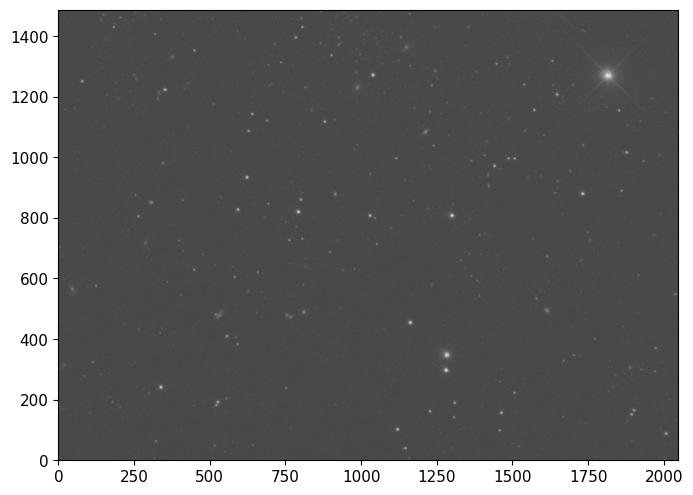

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.log(image[0] - np.min(image[0]) + 10), origin='lower', cmap='gray')    # SDSS image has origin in lower left

#### Crop to quarter size for efficiency

(1, 744, 1024)


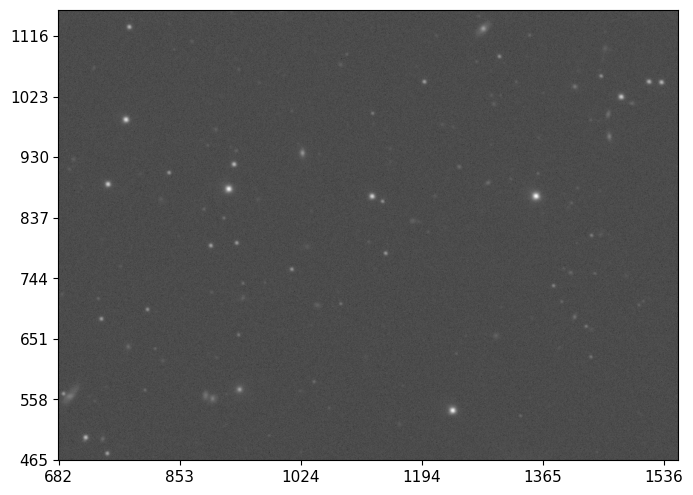

In [12]:
# crop to center
height, width = image[0].shape
min_h, min_w = height // 4, width // 4
max_h, max_w = min_h * 3, min_w * 3
cropped_image = image[:, min_h:max_h, min_w:max_w]

fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.imshow(np.log(cropped_image[0] - np.min(cropped_image[0]) + 10), origin='lower', cmap='gray')
ax2.set_xticklabels(np.linspace(min_w, max_w, 7, dtype=np.int32))
ax2.set_yticklabels(np.linspace(min_h, max_h, 9, dtype=np.int32))
print(cropped_image.shape)

cropped_background = background[:, min_h:max_h, min_w:max_w]

#### Make make predictions on cropped image

In [13]:
batch = {
    "images": prepare_image(cropped_image, cfg.predict.device),
    "background": prepare_image(cropped_background, cfg.predict.device)
}

with torch.no_grad():
    pred = encoder.encode_batch(batch)
    bliss_cat = encoder.variational_mode(pred)
    print("{} light sources detected".format(bliss_cat.n_sources.item()))

bliss_cat.plocs = bliss_cat.plocs + torch.tensor([min_h + 4, min_w + 4]).to(device)

180 light sources detected


#### Find bounds of image in RA and DEC and use to load SDSS and DECaLS catalogs

In [14]:
ra_lim, dec_lim = wcs.all_pix2world((min_w, max_w), (min_h, max_h), 0)
print(ra_lim)
print(dec_lim)

[     336.62      336.71]
[   -0.98787    -0.87524]


In [15]:
def _get_photo_cat(photo_cat, ra_lim, dec_lim):
    """Helper function to restrict photo catalog to within RA and DEC limits."""
    ra = photo_cat["ra"].squeeze()
    dec = photo_cat["dec"].squeeze()

    keep = (ra > ra_lim[0]) & (ra < ra_lim[1]) & (dec >= dec_lim[0]) & (dec <= dec_lim[1])
    plocs = photo_cat.plocs[:, keep]
    n_sources = torch.tensor([plocs.size()[1]])

    d = {"plocs": plocs, "n_sources": n_sources}
    for key in photo_cat.keys():
        d[key] = photo_cat[key][:, keep]

    return PhotoFullCatalog(
        plocs[0,:,0].max() - plocs[0,:,0].min(),  # new height
        plocs[0,:,1].max() - plocs[0,:,1].min(),  # new width
        d
    )

def _get_decals_cat(filename, ra_lim, dec_lim, wcs):
    """Helper function to load DECaLS data for test cases."""
    cat = DecalsFullCatalog.from_file(filename, ra_lim, dec_lim)

    # if provided, use WCS to convert RA and DEC to plocs
    if wcs is not None:
        plocs = cat.get_plocs_from_ra_dec(wcs)
        cat.plocs = plocs
        cat.height, cat.width = wcs.array_shape

    return cat        

In [16]:
decals_path = Path(cfg.paths.decals).joinpath("tractor-3366m010.fits")
new_photo_cat = _get_photo_cat(photo_cat, ra_lim, dec_lim)
decals_cat = _get_decals_cat(decals_path, ra_lim, dec_lim, wcs)

In [17]:
# Check sources in photo cat are within bounds
assert new_photo_cat["ra"].min() >= ra_lim[0] and new_photo_cat["ra"].max() <= ra_lim[1]
assert new_photo_cat["dec"].min() >= dec_lim[0] and new_photo_cat["dec"].max() <= dec_lim[1]

In [18]:
# Check sources in decals cat are within bounds
assert decals_cat["ra"].min() >= ra_lim[0] and decals_cat["ra"].max() <= ra_lim[1]
assert decals_cat["dec"].min() >= dec_lim[0] and decals_cat["dec"].max() <= dec_lim[1]

In [19]:
print(f"{decals_cat.n_sources.item()} sources in DECaLS")
print(f"{new_photo_cat.n_sources.item()} sources in SDSS")
print(f"{bliss_cat.n_sources.item()} sources predicted by BLISS")

1336 sources in DECaLS
200 sources in SDSS
180 sources predicted by BLISS


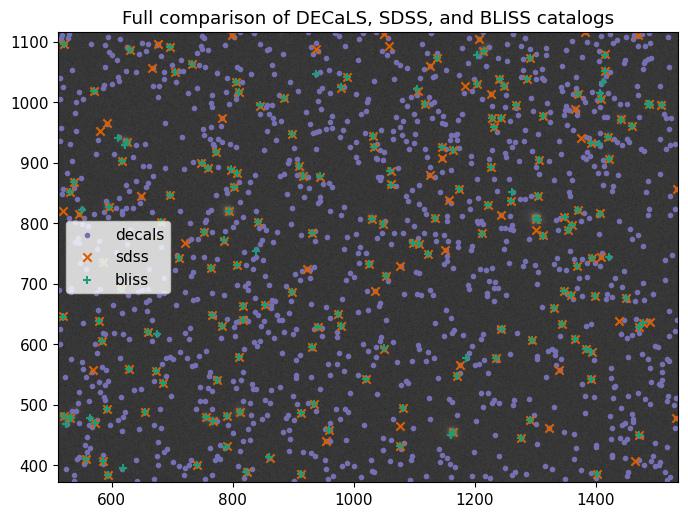

In [20]:
fig3, ax3 = plt.subplots(figsize=(8, 8))

decals_color = "#7570b3"
sdss_color = "#d95f02"
bliss_color = "#1b9e77"

ax3.scatter(
    decals_cat.plocs[0,:,1], decals_cat.plocs[0,:,0],
    c=decals_color, marker=".", label="decals")
ax3.scatter(
    new_photo_cat.plocs[0,:,1], new_photo_cat.plocs[0,:,0],
    c=sdss_color, marker="x", label="sdss")
ax3.scatter(
    bliss_cat.plocs.cpu()[0,:,1], bliss_cat.plocs.cpu()[0,:,0],
    c=bliss_color, marker="+", label="bliss")

ax3.imshow(
    np.log(cropped_image[0] - np.min(cropped_image[0]) + 30),
    cmap='gray',
    origin='lower',
    extent=(min_w - 0.5, max_w + 0.5, min_h - 0.5, max_h + 0.5)
)
ax3.legend()
ax3.set_title('Full comparison of DECaLS, SDSS, and BLISS catalogs');

In [21]:
# make sure decals and sdss catalogs agree with themselves
metrics_d_vs_d = metrics(decals_cat, decals_cat)
metrics_s_vs_s = metrics(new_photo_cat, new_photo_cat)

assert metrics_d_vs_d['f1'] == metrics_s_vs_s['f1']

In [22]:
# check sdss catalog agrees with decals
metrics_d_vs_s = metrics(decals_cat, new_photo_cat)
print(metrics_d_vs_s['precision'])
assert metrics_d_vs_s['precision'] > 0.8

tensor(0.85500)


#### Restrict catalogs to brightest stars to compare with BLISS

In [23]:
top_n = 180
decals_flux = decals_cat["fluxes"].squeeze()
top_n_decals = torch.argsort(decals_flux)[-top_n:]
decals_locs = decals_cat.plocs[:, top_n_decals]

photo_flux = new_photo_cat["fluxes"].squeeze()
top_n_photo = torch.argsort(photo_flux)[-top_n:]
photo_locs = new_photo_cat.plocs[:, top_n_photo]

bliss_fluxes = bliss_cat["star_fluxes"] * bliss_cat["star_bools"] + bliss_cat["galaxy_params"][:,:,0,None] * bliss_cat["galaxy_bools"]
bliss_flux = bliss_fluxes.squeeze()
top_n_bliss = torch.argsort(bliss_flux)[-top_n:]
bliss_locs = bliss_cat.plocs[:, top_n_bliss]

In [24]:
# normalize fluxes to use as size
s_decals = torch.log(decals_flux - torch.min(decals_flux) + 1)[top_n_decals]
s_decals = ((s_decals / torch.max(s_decals)) * 180) + 20

s_photo = torch.log(photo_flux - torch.min(photo_flux) + 1)[top_n_photo]
s_photo = ((s_photo / torch.max(s_photo)) * 180) + 20

s_bliss = torch.log(bliss_flux - torch.min(bliss_flux) + 1)[top_n_bliss]
s_bliss = ((s_bliss / torch.max(s_bliss)) * 180) + 20

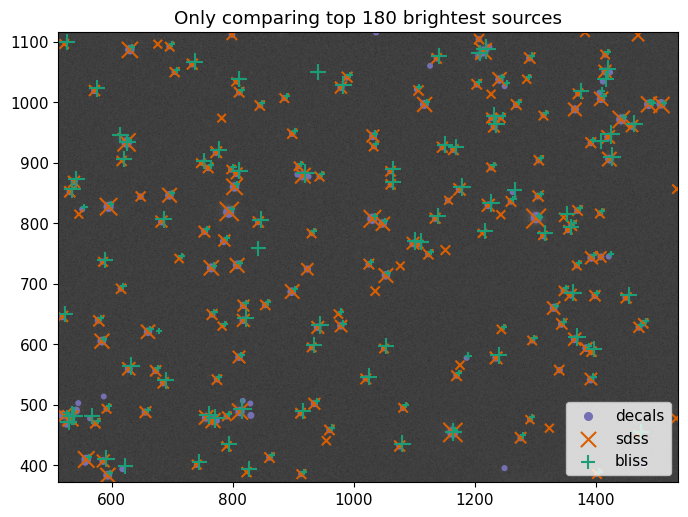

In [25]:
fig4, ax4 = plt.subplots(figsize=(8, 8))
ax4.scatter(
    decals_locs[0,:,1], decals_locs[0,:,0],
    c=decals_color, s=s_decals, marker=".", label="decals")
ax4.scatter(
    photo_locs[0,:,1], photo_locs[0,:,0],
    c=sdss_color, s=s_photo, marker="x", label="sdss")
ax4.scatter(
    bliss_locs.cpu()[0,:,1] + 4, bliss_locs.cpu()[0,:,0] + 4,
    c=bliss_color, s=s_bliss.cpu(), marker="+", label="bliss")

ax4.imshow(
    np.log(cropped_image[0] - np.min(cropped_image[0]) + 20),
    cmap='gray',
    origin='lower',
    extent=(min_w - 0.5, max_w + 0.5, min_h - 0.5, max_h + 0.5)
)

ax4.legend()
ax4.set_title(f"Only comparing top {top_n} brightest sources");

In [26]:
# construct new catalogs for metrics
decals_d = {
    "plocs": decals_locs.to(device),
    "n_sources": torch.tensor([top_n]).to(device),
    "galaxy_bools": decals_cat["galaxy_bools"][:,top_n_decals,:].to(device)
}
top_n_decals_cat = DecalsFullCatalog(decals_cat.height, decals_cat.width, decals_d)

photo_d = {
    "plocs": photo_locs.to(device),
    "n_sources": torch.tensor([top_n]).to(device),
    "galaxy_bools": photo_cat["galaxy_bools"][:,top_n_photo,:].to(device)
}
top_n_photo_cat = PhotoFullCatalog(photo_cat.height, photo_cat.width, photo_d)

bliss_d = {
    "plocs": bliss_locs.to(device),
    "n_sources": torch.tensor([top_n]).to(device),
    "galaxy_bools": bliss_cat["galaxy_bools"][:,top_n_bliss,:].to(device)
}
top_n_bliss_cat = FullCatalog(bliss_cat.height, bliss_cat.width, bliss_d)

In [27]:
# bliss vs photo
device = torch.device("cpu")
BlissMetrics(slack=5.0)(top_n_photo_cat.to(device), top_n_bliss_cat.to(device))

{'tp': tensor(157),
 'fp': tensor(23),
 'precision': tensor(0.87222),
 'recall': tensor(0.87222),
 'f1': tensor(0.87222),
 'avg_distance': tensor(23.40972),
 'n_matches': tensor(157),
 'n_matches_gal_coadd': tensor(63),
 'class_acc': tensor(0.58599),
 'gal_tp': tensor(19),
 'gal_fp': tensor(21),
 'gal_fn': tensor(44),
 'gal_tn': tensor(73)}

In [28]:
# bliss vs decals
BlissMetrics(slack=5.0)(top_n_decals_cat.to(device), top_n_bliss_cat.to(device))

{'tp': tensor(156),
 'fp': tensor(24),
 'precision': tensor(0.86667),
 'recall': tensor(0.86667),
 'f1': tensor(0.86667),
 'avg_distance': tensor(21.50867),
 'n_matches': tensor(156),
 'n_matches_gal_coadd': tensor(60),
 'class_acc': tensor(0.85897),
 'gal_tp': tensor(59),
 'gal_fp': tensor(21),
 'gal_fn': tensor(1),
 'gal_tn': tensor(75)}